In [1]:
%load_ext autoreload
%autoreload 2

In [96]:
import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
import jax
import matplotlib.pyplot as plt
import pandas as pd

import numpyro
import arviz as az

from src import igp, data, plot as plot_utils

print(jax.devices())
jax.config.update("jax_enable_x64", True)


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4)]


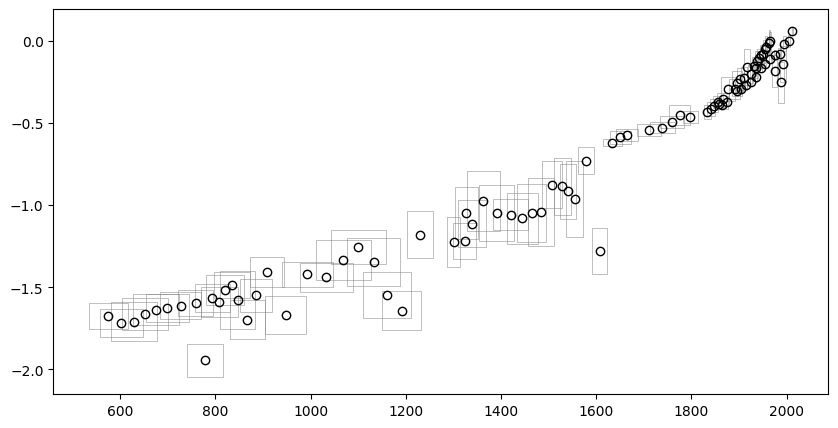

In [97]:
# load data
# age should be in AD

df = pd.read_csv("./data/NYC.csv")

plt.figure(figsize=(10, 5))
plot_utils.plot_input(df)

In [84]:
eiv_input = data.preprocess(df, gia_rate=0)
print(eiv_input.keys())

dict_keys(['x', 'y', 'cov', 'x_star', 'x_unscaled'])


# MCMC


In [ ]:
mcmc = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        igp.eiv_igp,
        dense_mass=True,
    ),
    num_warmup=200,
    num_samples=500,
    num_chains=1,
)
mcmc.run(
    jax.random.PRNGKey(1),
    **eiv_input,
    simplify=False,
)
mcmc.print_summary()

sample: 100%|██████████| 700/700 [26:00<00:00,  2.23s/it, 127 steps of size 1.16e-01. acc. prob=0.83]   


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -1.71      0.06     -1.70     -1.78     -1.60    375.74      1.00
         p      0.11      0.19      0.03      0.00      0.35     11.92      1.14
     sigma      0.02      0.01      0.02      0.01      0.03     20.97      1.07
     tau_g      0.10      0.03      0.10      0.05      0.15    184.31      1.01
    w_m[0]      0.28      0.88      0.30     -1.20      1.57    356.63      1.00
    w_m[1]      0.35      0.67      0.36     -0.58      1.57    378.06      1.00
    w_m[2]      0.40      0.54      0.40     -0.41      1.30    396.00      1.00
    w_m[3]      0.45      0.43      0.43     -0.19      1.21    409.19      1.00
    w_m[4]      0.50      0.35      0.49     -0.07      1.03    380.11      1.00
    w_m[5]      0.53      0.29      0.53      0.11      1.04    371.34      1.00
    w_m[6]      0.56      0.26      0.55      0.15      0.96    338.29      1.00
    w_m[7]      0.58      0

In [ ]:
samples = mcmc.get_samples()
derp, intp = igp.get_predictions_on_grid(samples, eiv_input)

az.plot_hdi(eiv_input["x_star"], intp[None, :, :], color="C0")
plt.plot(eiv_input["x_star"], intp.mean(axis=0))
plt.show()
az.plot_hdi(eiv_input["x_star"], derp[None, :, :], color="C0")
plt.plot(eiv_input["x_star"], derp.mean(axis=0))
plt.show()

# SVI


In [86]:
from numpyro.infer import SVI, Trace_ELBO, autoguide
import optax

guide = autoguide.AutoMultivariateNormal(igp.eiv_igp)
optimizer = optax.adamw(learning_rate=1e-2)
svi = SVI(igp.eiv_igp, guide, optimizer, loss=Trace_ELBO())

svi_result = svi.run(
    jax.random.PRNGKey(0),
    num_steps=10_000,
    **eiv_input,
    progress_bar=False,
)

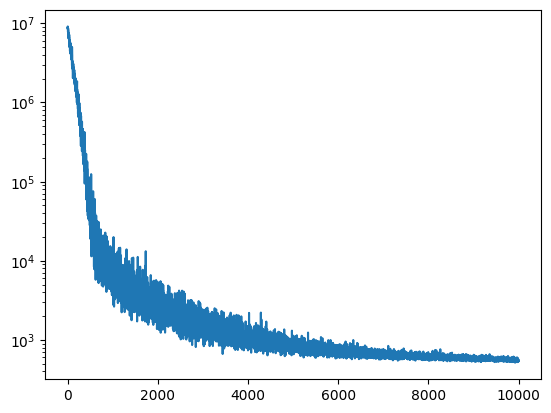

In [87]:
plt.plot(svi_result.losses)
plt.yscale("log")

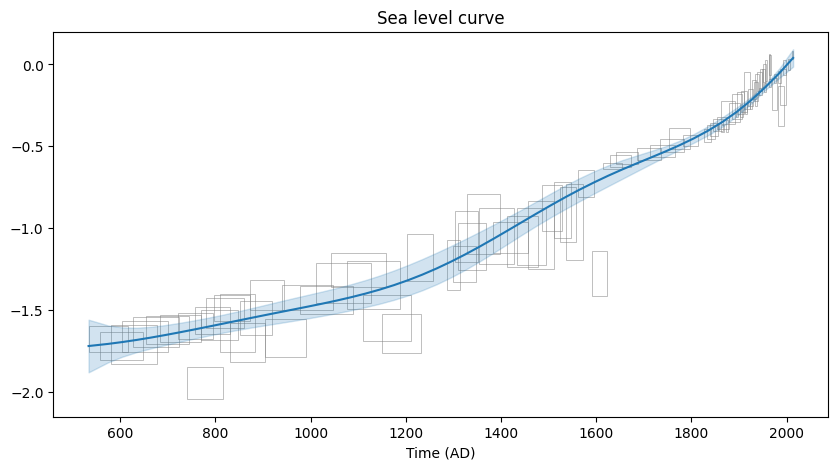

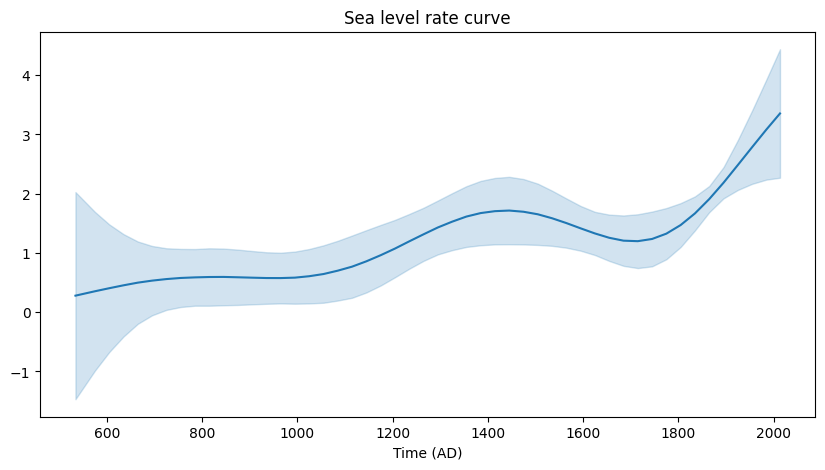

In [98]:
samples_svi = guide.sample_posterior(
    jax.random.PRNGKey(1),
    svi_result.params,
    sample_shape=(1000,),  # Number of samples to draw
)

derp, intp = igp.get_predictions_on_grid(samples, eiv_input)

plt.figure(figsize=(10, 5))
plot_utils.plot_input(df, points=False)
# plots mean+2sd
plot_utils.plot_samples(eiv_input, intp)
plt.title("Sea level curve")
plt.xlabel("Time (AD)")
plt.show()


# plot derivative curve
plt.figure(figsize=(10, 5))
plot_utils.plot_samples(eiv_input, derp)
plt.title("Sea level rate curve")
plt.xlabel("Time (AD)")
plt.show()
